In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

In [2]:
class TextureDataset(Dataset):
    def __init__(self, diff_dir, disp_dir, nor_dir, rough_dir,transform=None):
        self.diff = diff_dir
        self.disp = disp_dir
        self.nor = nor_dir
        self.rough= rough_dir
        self.transform = transform
    def __len__(self):
        return len(os.listdir(self.diff))
    def __getitem__(self,idx):
        img_name = os.listdir(self.diff)[idx][:-11]
        diff_img = Image.open(self.diff+"/"+img_name+"diff_1k.jpg").convert('RGB')
        disp_img = Image.open(self.disp+"/"+img_name+"disp_1k.jpg").convert('L')
        nor_img = Image.open(self.nor+"/"+img_name+"nor_1k.jpg")
        rough_img = Image.open(self.rough+"/"+img_name+"rough_1k.jpg").convert('L')
        img_list = [diff_img, disp_img, nor_img, rough_img]
        seed = np.random.randint(2147483647)

        if self.transform is not None:
            for i, img in enumerate(img_list):
                random.seed(seed)
                torch.manual_seed(seed)
                img_list[i] = self.transform(img)

        return {"diff": img_list[0], "disp": img_list[1], "nor": img_list[2], "rough":img_list[3]}

In [3]:
data_transform = transforms.Compose([
        transforms.RandomCrop(900),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
    ])

In [4]:
diff_dir = "./Data/diff"
disp_dir = "./Data/disp"
nor_dir = "./Data/nor"
rough_dir = "./Data/rough"
dataset = TextureDataset(diff_dir, disp_dir, nor_dir, rough_dir, transform = data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle =True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [5]:
from resnet import ResNet

device = torch.device("cuda")

model = ResNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss().to(device)

In [6]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    loss2 = 0
    for data in train_dataloader:
        x= data["diff"].to(device)
        y_disp= data["disp"].to(device)
        y_norm= data["nor"].to(device)
        y_rough= data["rough"].to(device)
        optimizer.zero_grad()
        out_disp, out_norm, out_rough= model(x)
        
        train_loss = (criterion(out_disp, y_disp) + criterion(out_norm, y_norm) + criterion(out_rough, y_rough))/3
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    for data in test_dataloader:
        x= data["diff"].to(device)
        y_disp= data["disp"].to(device)
        y_norm= data["nor"].to(device)
        y_rough= data["rough"].to(device)

        out_disp, out_norm, out_rough= model(x)
        test_loss = (criterion(out_disp, y_disp) + criterion(out_norm, y_norm) + criterion(out_rough, y_rough))/3
        loss2 += test_loss.item() 
        
    loss = loss / len(train_dataloader)
    loss2 = loss2 / len(test_dataloader)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, testloss = {:.6f}".format(epoch + 1, epochs, loss,loss2))

epoch : 1/20, loss = 0.366154, testloss = 0.287740
epoch : 2/20, loss = 0.244712, testloss = 0.192776
epoch : 3/20, loss = 0.156913, testloss = 0.115315
epoch : 4/20, loss = 0.088035, testloss = 0.068783
epoch : 5/20, loss = 0.052436, testloss = 0.044484
epoch : 6/20, loss = 0.040893, testloss = 0.043460
epoch : 7/20, loss = 0.034530, testloss = 0.043645
epoch : 8/20, loss = 0.031806, testloss = 0.033910
epoch : 9/20, loss = 0.030598, testloss = 0.037355
epoch : 10/20, loss = 0.030308, testloss = 0.029328
epoch : 11/20, loss = 0.029158, testloss = 0.026114
epoch : 12/20, loss = 0.027137, testloss = 0.024938
epoch : 13/20, loss = 0.028001, testloss = 0.033125
epoch : 14/20, loss = 0.026990, testloss = 0.027887
epoch : 15/20, loss = 0.027769, testloss = 0.029539
epoch : 16/20, loss = 0.027329, testloss = 0.030766
epoch : 17/20, loss = 0.027264, testloss = 0.031129
epoch : 18/20, loss = 0.027861, testloss = 0.024847
epoch : 19/20, loss = 0.027157, testloss = 0.025322
epoch : 20/20, loss =

In [7]:
import torchvision.utils as vutils
data = next(iter(test_dataloader))
diff = data["diff"]
disp = data["disp"]
norm = data["nor"]
rough = data["rough"]
out_disp, out_norm, out_rough = model(diff.to(device))

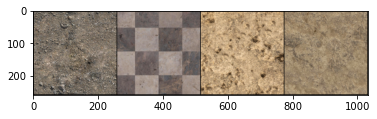

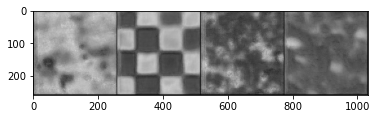

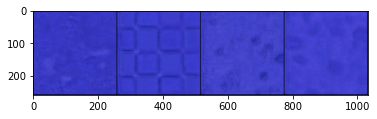

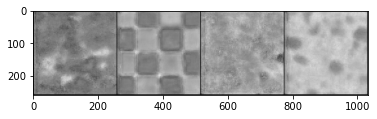

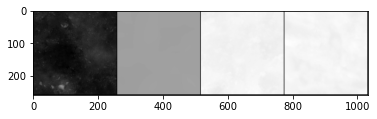

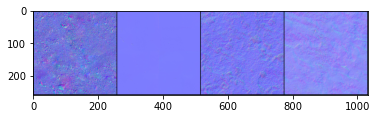

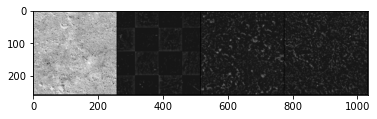

In [16]:
out_img = np.transpose(vutils.make_grid(diff[0:4], normalize=True),(1,2,0))
plt.imshow(out_img)
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(out_disp[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(out_norm[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(out_rough[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(disp[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(norm[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(rough[0:4].detach().cpu(), normalize=True),(1,2,0)))


In [9]:
torch.save(model.state_dict(),"./Model/model.pt")

In [10]:
model.load_state_dict(torch.load("./Model/model.pt"))
model.eval()

ResNet(
  (model_head): Sequential(
    (0): Conv2d(3, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (resize): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Seq

In [18]:
img_direc =os.listdir("./other")

In [34]:
img_name[:-4]

'myoutput6'

In [42]:
for img_name in os.listdir("./other"):
    img = Image.open("./other/"+img_name)
    test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
        ])
    img = test_transform(img).view(1,3,256,256)
    out_disp, out_norm, out_rough = model(img.to(device))

    disp = transforms.ToPILImage()(out_disp[0].detach().cpu()).convert("L")
    norm = transforms.ToPILImage()(out_norm[0].detach().cpu()).convert("RGB")
    rough =transforms.ToPILImage()(out_rough[0].detach().cpu()).convert("L")
    direc_name = "./generated_map/"+img_name[:-4]
    try:
        # Create  Directory  MyDirectory 
        os.mkdir("./generated_map/"+img_name[:-4])
    except FileExistsError:
        pass
    img.save(direc_name+"/"+img_name[:-4]+"_diff.jpg")
    disp.save(direc_name+"/"+img_name[:-4]+"_disp.jpg")
    norm.save(direc_name+"/"+img_name[:-4]+"_nor.jpg")
    rough.save(direc_name+"/"+img_name[:-4]+"_rough.jpg")